In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
train=pd.read_csv('train.csv')
df=train.copy()

test=pd.read_csv('test.csv')
df_test=test.copy()

**View columns with null values**

In [7]:
null=df.isna().sum().sort_values(ascending=False)
null[null.values>0]

,0
visit_count,29595
age,3


In [8]:
null=df_test.isna().sum().sort_values(ascending=False)
null[null.values>0]

,0
visit_count,5250
age,1


**View duplicate values**

In [9]:
len(df[df.duplicated()])

6

In [10]:
len(df_test[df_test.duplicated()])

0

Correction of referral

In [11]:
referral_mapping = {
    'Alone': 'Alone',
    'With a companion': 'With a companion',
    'Ambulance': 'Ambulance',
    'Police': 'Ambulance',
    'OtherHospital': 'Other',
    'OtherCity': 'Other',
    'other': 'Other',
    'Unknown': 'Other'
}

df['referral'] = df['referral'].replace(referral_mapping)
df_test['referral'] = df_test['referral'].replace(referral_mapping)

Triage correction

In [12]:
df['triage'] = df['triage'].replace({
    "Level 4 – Semi-urgent": "Low",
    "Level 5 – Non-urgent": "Low",
    "Level 3 – Urgent": "Medium",
    "Level 2 – Emergency": "High",
    "Level 1 – Immediate": "Critical"
})

df_test['triage'] = df_test['triage'].replace({
    "Level 4 – Semi-urgent": "Low",
    "Level 5 – Non-urgent": "Low",
    "Level 3 – Urgent": "Medium",
    "Level 2 – Emergency": "High",
    "Level 1 – Immediate": "Critical"
})

Fixing problems with null and duplicate rows and errors

In [13]:
df.drop_duplicates(inplace=True)
df.dropna(subset='age',how='any',inplace=True)
df_test.loc[df_test['age'].isna(),'age']=39
df.drop(axis=0,index=54466,inplace=True)
df.loc[df['visit_count'].isna(),'visit_count']=0
df_test.loc[df_test['visit_count'].isna(),'visit_count']=0
df['accident']=df['accident'].str.replace('A03 : چهارشنبه سوري','wednesday_lastyear')
df_test['accident']=df_test['accident'].str.replace('A03 : چهارشنبه سوري','wednesday_lastyear')

**Checking for outliers**

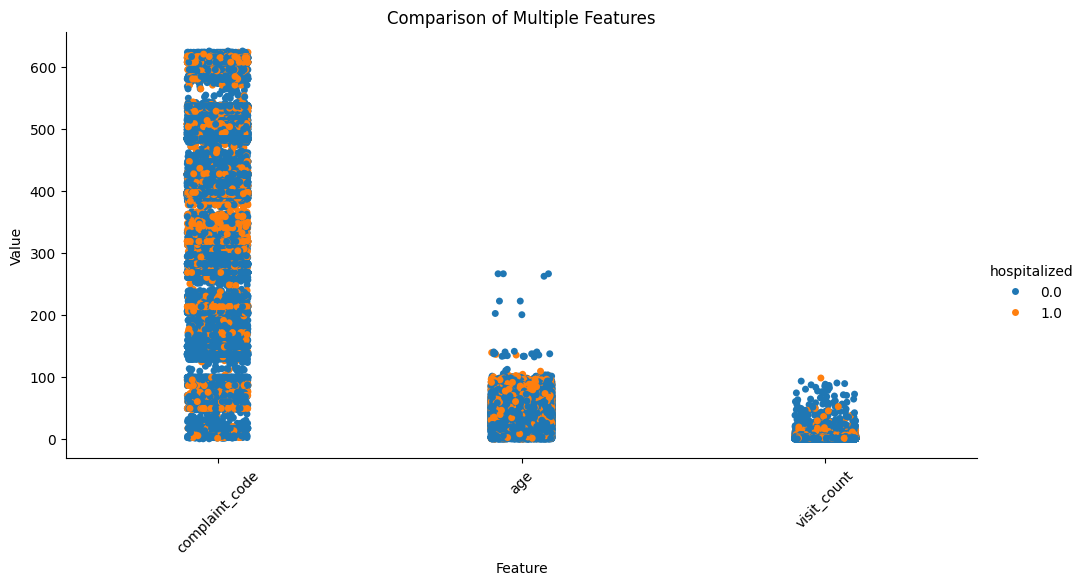

In [14]:
df_melted = df.melt(id_vars=['hospitalized'], value_vars=[ 'complaint_code', 'age', 'visit_count'], var_name='Feature', value_name='Value')

sns.catplot(x='Feature', y='Value', hue='hospitalized', data=df_melted, kind='strip', height=5, aspect=2)

plt.xticks(rotation=45)
plt.title("Comparison of Multiple Features")
plt.show()

In [15]:
fig=px.histogram(data_frame=df,x='age',nbins=50,marginal='box')
fig.show()

**Solving the problem of outliers in age and number of visits**

In [16]:
df.loc[df['age']>100,'age']=100
df_test.loc[df_test['age']>100,'age']=100

df.loc[df['visit_count']>50,'visit_count']=52
df_test.loc[df_test['visit_count']>50,'visit_count']=52

In [17]:
# quantile = df['visit_count'].quantile(0.99)

# # 📌 جایگزین مقدارهای پرت با مقدار صدک ۹۹
# df['visit_count'] = np.where(df['visit_count'] > quantile, quantile, df['visit_count'])


**Distribution of hospitalized and non-hospitalized patients**

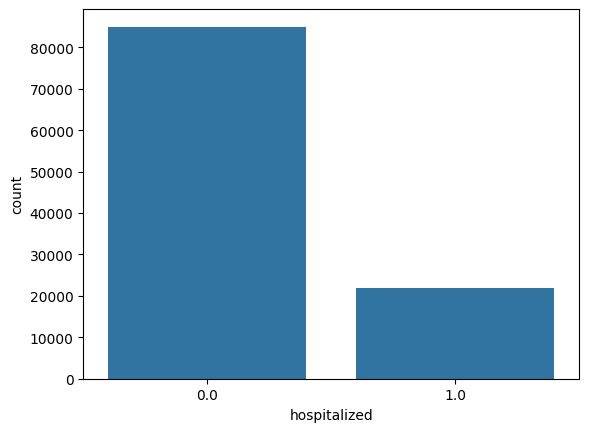

In [18]:
sns.countplot(data=df,x='hospitalized')
plt.show()

Converting solar date to Gregorian date

In [19]:
!pip install jdatetime
import jdatetime

In [20]:
def convert_shamsi_to_gregorian(date_str):
    try:
        year, month, day = map(int, date_str.split('/'))
        gregorian_date = jdatetime.date(year, month, day).togregorian()
        return gregorian_date.strftime('%Y-%m-%d')
    except:
        return None

df['gregorian_date'] = df['triage_date'].apply(convert_shamsi_to_gregorian)
df.insert(loc=1,column='triage_datetime',value=pd.to_datetime(df['gregorian_date'] + ' ' + df['triage_time'], errors='coerce'))


In [21]:

def convert_shamsi_to_gregorian_test(date_str):
    try:
        year, month, day = map(int, date_str.split('/'))
        gregorian_date = jdatetime.date(year, month, day).togregorian()
        return gregorian_date.strftime('%Y-%m-%d')
    except:
        return None

df_test['gregorian_date'] = df_test['triage_date'].apply(convert_shamsi_to_gregorian_test)
df_test.insert(loc=1,column='triage_datetime',value=pd.to_datetime(df_test['gregorian_date'] + ' ' + df_test['triage_time'], errors='coerce'))


Create columns for month, weekday, weekend, minutes, and hours

In [22]:
df.insert(loc=1,column='triage_month',value=df['triage_datetime'].dt.month)
df.insert(loc=2,column='triage_dayofweek',value=df['triage_datetime'].dt.dayofweek)
df.insert(loc=3,column='triage_hour',value=df['triage_datetime'].dt.hour)
df.insert(loc=4,column='triage_weekend',value=(df['triage_datetime'].dt.weekday >= 5).astype(float))
df.insert(loc=5,column='minutes_since_midnight',value=df['triage_hour'] * 60 + df['triage_datetime'].dt.minute)

In [23]:
df_test.insert(loc=1,column='triage_month',value=df_test['triage_datetime'].dt.month)
df_test.insert(loc=2,column='triage_dayofweek',value=df_test['triage_datetime'].dt.dayofweek)
df_test.insert(loc=3,column='triage_hour',value=df_test['triage_datetime'].dt.hour)
df_test.insert(loc=4,column='triage_weekend',value=(df_test['triage_datetime'].dt.weekday >= 5).astype(float))
df_test.insert(loc=5,column='minutes_since_midnight',value=df_test['triage_hour'] * 60 + df_test['triage_datetime'].dt.minute)

Removing unnecessary and useless columns

In [24]:
df.drop(columns=['triage_date','triage_time','triage_datetime','gregorian_date'],inplace=True)
df_test.drop(columns=['triage_date','triage_time','triage_datetime','gregorian_date'],inplace=True)

df.drop(columns=["succesful_cpr", "failed_cpr","no_vitals"], inplace=True)
df_test.drop(columns=["succesful_cpr", "failed_cpr","no_vitals"], inplace=True)

**Hospitalization pattern at different times of the day**

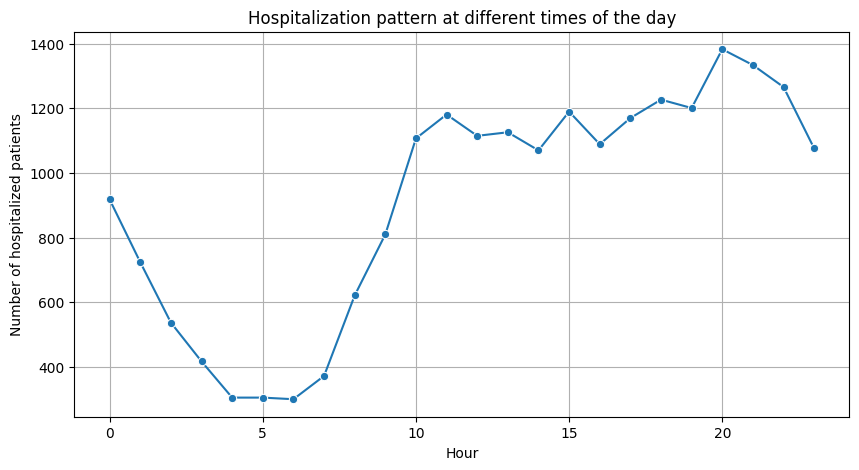

In [25]:
hourly_trend = df.groupby('triage_hour')['hospitalized'].sum()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_trend.index, y=hourly_trend.values, marker='o')
plt.title('Hospitalization pattern at different times of the day')
plt.xlabel('Hour')
plt.ylabel('Number of hospitalized patients')
plt.grid()
plt.show()


**Average hospitalizations by month of the year**

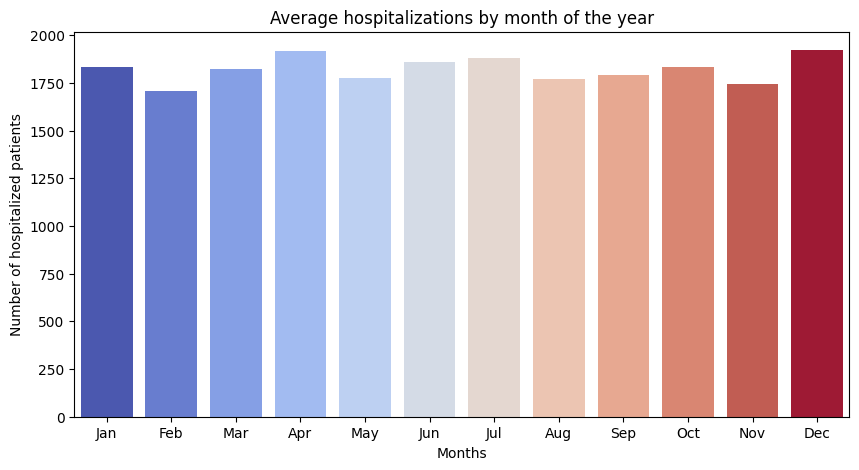

In [26]:

monthly_trend = df.groupby('triage_month')['hospitalized'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(
    x="triage_month",
    y="hospitalized",
    data=monthly_trend,
    palette="coolwarm",
    hue="triage_month",
    legend=False
)

plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Average hospitalizations by month of the year')
plt.xlabel('Months')
plt.ylabel('Number of hospitalized patients')
plt.show()

**Average number of hospitalized patients on weekdays**

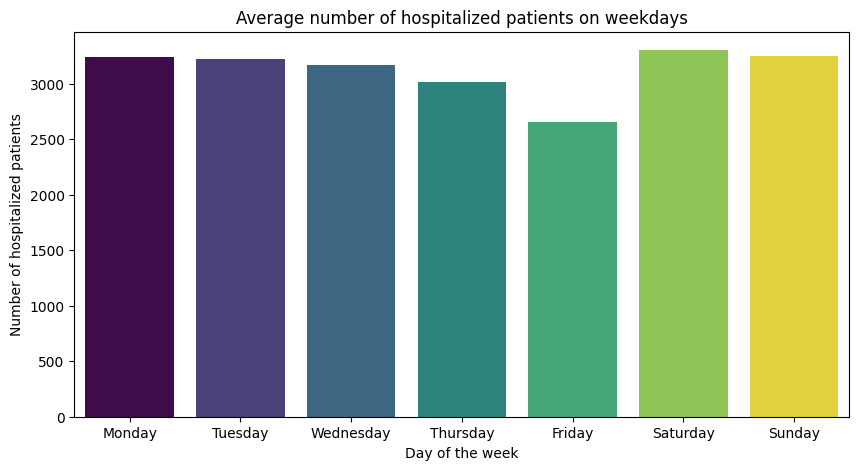

In [27]:
weekly_trend = df.groupby('triage_dayofweek')['hospitalized'].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=weekly_trend,x='triage_dayofweek', y='hospitalized', palette="viridis",hue='triage_dayofweek',legend=False)
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average number of hospitalized patients on weekdays')
plt.xlabel('Day of the week')
plt.ylabel('Number of hospitalized patients')
plt.show()

**Create an age group**

In [28]:
bins = [0, 1, 12, 18, 35, 60, 120]
labels = [2,1,3,4,5,6]

df['age_group'] = pd.cut(df['age'], bins=bins,  labels=labels)

df_test['age_group'] = pd.cut(df_test['age'], bins=bins,  labels=labels)

df['age_group'] = df['age_group'].fillna(3)
df_test['age_group'] = df_test['age_group'].fillna(3)

**Comparison of hospitalization rates based on gender + age + severity of illness**

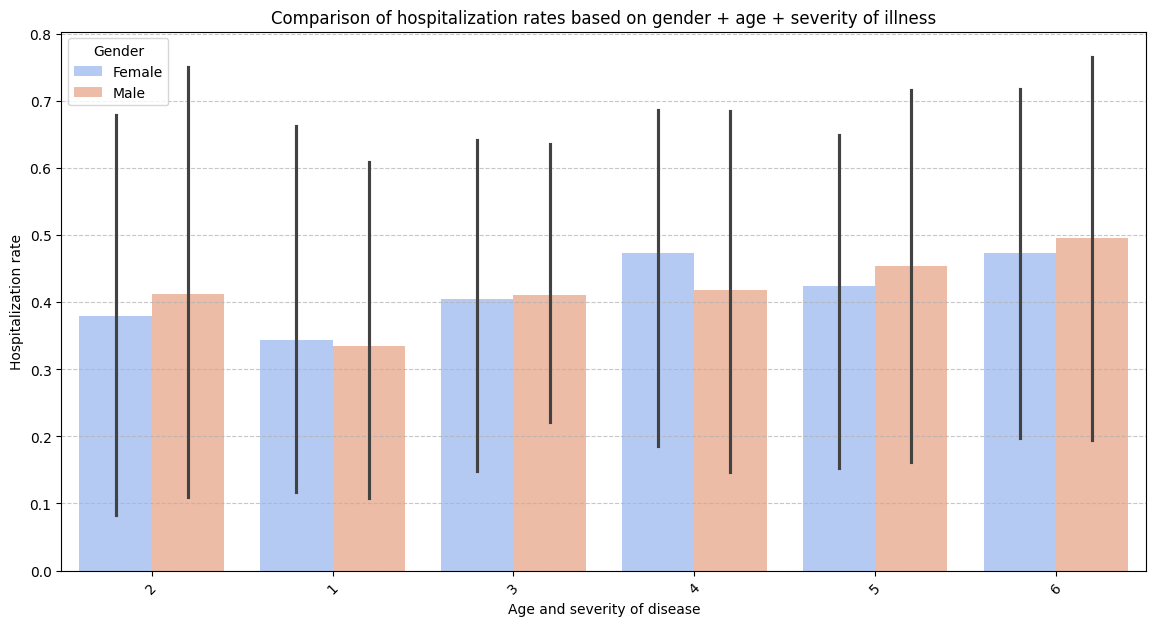

In [29]:
grouped = df.groupby(['gender', 'age_group', 'triage'],observed=True).agg(
    hospitalization_rate=('hospitalized', 'mean')  # محاسبه میانگین بستری
).reset_index()
grouped.rename(columns={'hospitalization_rate':'gender_age_triage_hospotalized'},inplace=True)
df=pd.merge(left=df,right=grouped[['gender', 'age_group', 'triage','gender_age_triage_hospotalized']],how='left',on=['gender', 'age_group', 'triage'])
df_test=pd.merge(left=df_test,right=grouped[['gender', 'age_group', 'triage','gender_age_triage_hospotalized']],how='left',on=['gender', 'age_group', 'triage'])
df_test['gender_age_triage_hospotalized']=df_test['gender_age_triage_hospotalized'].fillna(df['hospitalized'].mean())
# 📊 رسم نمودار میله‌ای خوشه‌ای
plt.figure(figsize=(14, 7))
sns.barplot(
    x="age_group", y="gender_age_triage_hospotalized",
    hue="gender",  # نمایش خوشه‌ای بر اساس جنسیت
    data=grouped,
    palette="coolwarm",
    dodge=True  # ✅ تفکیک میله‌ها برای مقایسه بهتر
)

#  تنظیمات نمودار
plt.title("Comparison of hospitalization rates based on gender + age + severity of illness")
plt.xlabel("Age and severity of disease")
plt.ylabel("Hospitalization rate")
plt.xticks(rotation=45)  # چرخش برچسب‌های محور X برای خوانایی بهتر
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Admission rates based on triage and gender and adding this rate to testing data**

In [30]:
# محاسبه نرخ بستری برای ترکیب تریاژ و جنسیت در train
triage_gender_rates = df.groupby(['triage', 'gender'],observed=True)['hospitalized'].mean().reset_index()
triage_gender_rates.rename(columns={'hospitalized': 'triage_hospital_rate'}, inplace=True)

# افزودن نرخ به train و test
df = pd.merge(df, triage_gender_rates, on=['triage', 'gender'], how='left')
df_test = pd.merge(df_test, triage_gender_rates, on=['triage', 'gender'], how='left')

# جایگزینی مقادیر NaN در test با میانگین نرخ بستری (بدون استفاده از inplace=True)
mean_triage_rate = df['triage_hospital_rate'].mean()
df_test['triage_hospital_rate'] = df_test['triage_hospital_rate'].fillna(mean_triage_rate)  # اصلاح این خط

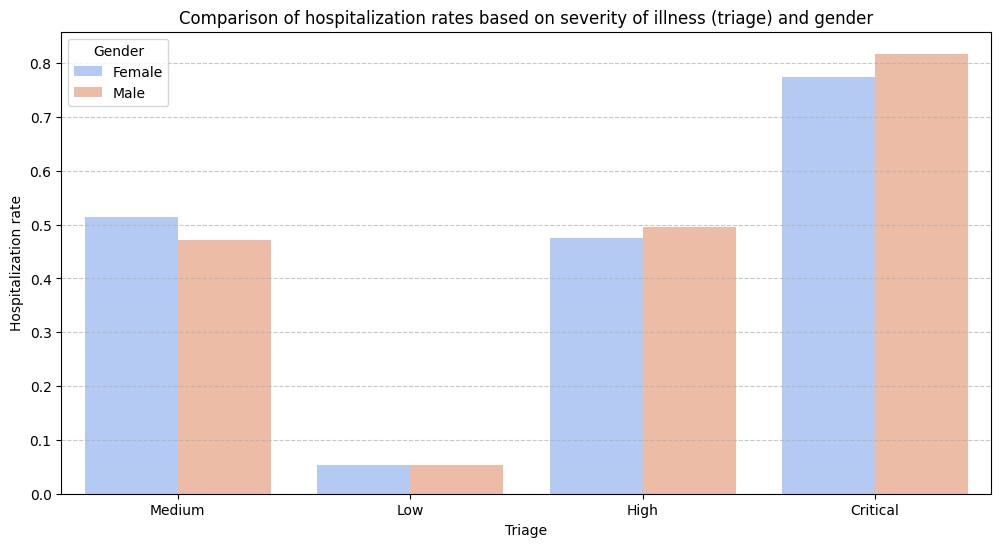

In [31]:

plt.figure(figsize=(12, 6))
sns.barplot(
    x='triage',
    y='triage_hospital_rate',
    hue='gender',  # تفکیک بر اساس جنسیت
    data=df,
    palette="coolwarm"
)

plt.title("Comparison of hospitalization rates based on severity of illness (triage) and gender")
plt.xlabel("Triage")
plt.ylabel("Hospitalization rate")
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Calculation of hospitalization rate based on gender triage and complaint code**

In [32]:
#  محاسبه نرخ بستری برای هر ترکیب تریاژ-جنسیت-کد
risk_groups_train = df.groupby(
    ['triage', 'gender', 'complaint_code'], observed=True  # ✅ مشخص کردن `observed=False`
).agg(
    total_cases=('hospitalized', 'size'),
    triage_gender_code_rate=('hospitalized', 'mean')
).reset_index()

risk_groups_train.set_index(['triage', 'gender', 'complaint_code'], inplace=True)

#  ادغام ویژگی‌ها با داده Train و Test
df = pd.merge(df, risk_groups_train['triage_gender_code_rate'], on=['triage', 'gender', 'complaint_code'], how='left')
df_test = pd.merge(df_test, risk_groups_train['triage_gender_code_rate'], on=['triage', 'gender', 'complaint_code'], how='left')

#  پر کردن مقادیر `NaN` در `df_test` با میانگین `hospitalized` در `df`
df_test['triage_gender_code_rate'] = df_test['triage_gender_code_rate'].fillna(df['hospitalized'].mean())

**Obtaining the average age and average hospitalization and number of complaint codes based on gender and complaint code**

In [33]:
# محاسبه میانگین سن و نرخ بستری برای هر ترکیب کد-جنسیت
combined_stats_train = df.groupby(['complaint_code', 'gender']).agg({ 'age': 'mean', 'hospitalized': 'mean', 'complaint_code': 'count'}).rename(columns={ 'age': 'avg_age',
    'hospitalized': 'code_gender_rate',
    'complaint_code': 'count'
}).reset_index()
combined_stats_train.set_index(['complaint_code', 'gender'],inplace=True)
df = pd.merge(df,combined_stats_train[['code_gender_rate','avg_age']],on=['complaint_code', 'gender'],how='left')
# ادغام ویژگی‌ها با داده Test (با استفاده از مقادیر Train)

df_test = pd.merge(df_test,combined_stats_train[['code_gender_rate','avg_age']],on=['complaint_code', 'gender'],how='left')
df_test['code_gender_rate'] = df_test['code_gender_rate'].fillna(df['hospitalized'].mean())
df_test['avg_age'] = df_test['avg_age'].fillna(df['age'].mean())

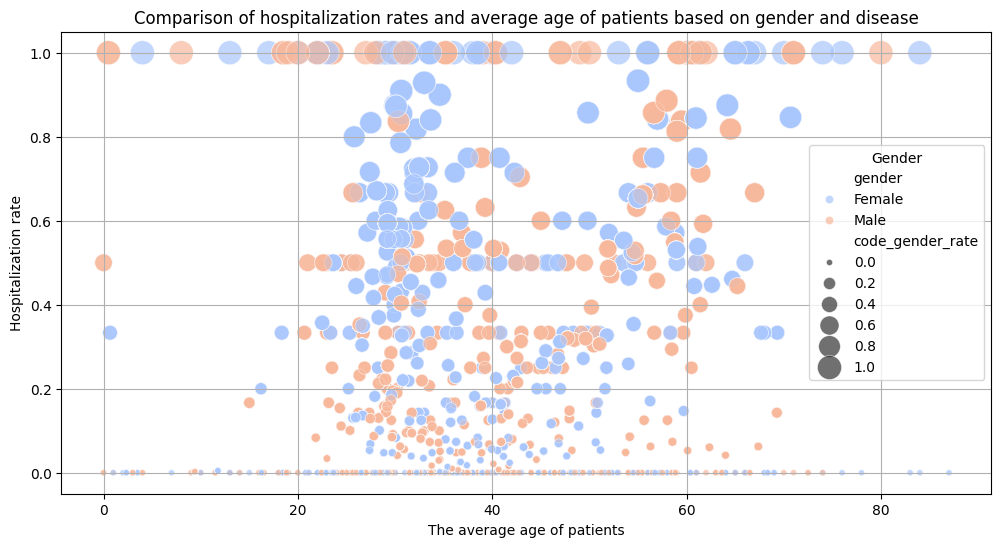

In [34]:

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=df['avg_age'],
    y=df['code_gender_rate'],
    hue=df['gender'],  # نمایش بر اساس جنسیت
    size=df['code_gender_rate'],  # اندازه دایره بر اساس نرخ بستری
    sizes=(20, 300),  # حداقل و حداکثر اندازه دایره‌ها
    alpha=0.7,
    palette="coolwarm"
)

plt.title("Comparison of hospitalization rates and average age of patients based on gender and disease")
plt.xlabel("The average age of patients")
plt.ylabel("Hospitalization rate")
plt.legend(title="Gender")
plt.grid(True)
plt.show()


**Grouping the number of visits**

In [35]:
df['visit_group'] = pd.cut(df['visit_count'], bins=[-1, 0, 3, 10, 100], labels=['new', 'low', 'medium', 'high'])
df_test['visit_group'] = pd.cut(df_test['visit_count'], bins=[-1, 0, 3, 10, 100], labels=['new', 'low', 'medium', 'high'])

**Hospitalization rate for each visit group**

In [36]:
visit_group_encoding = df.groupby('visit_group', observed=True)['hospitalized'].mean().to_dict()

# جایگزینی مقادیر در Train و Test
df['visit_group_encoded'] = df['visit_group'].map(visit_group_encoding)
df_test['visit_group_encoded'] = df_test['visit_group'].map(visit_group_encoding)
df['visit_group_encoded']=df['visit_group_encoded'].astype(float)
df_test['visit_group_encoded'] =df_test['visit_group_encoded'].astype(float)
# پر کردن مقادیر NaN در Test (اگر گروه جدیدی وجود دارد)
test_fill_value = df['visit_group_encoded'].mean()
df_test['visit_group_encoded'] = df_test['visit_group_encoded'].fillna(test_fill_value)

In [37]:
df["frequent_visitor"] = df["visit_count"].apply(lambda x: 1 if x > 1 else 0)
df_test["frequent_visitor"] = df_test["visit_count"].apply(lambda x: 1 if x > 1 else 0)

**Comparison of hospitalization rates between random and non-random patients**

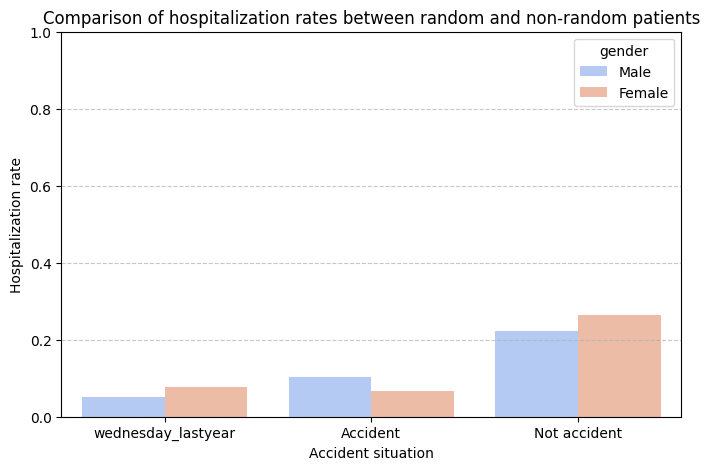

In [38]:
grouped_accident=df.groupby(['accident','gender'])['hospitalized'].mean().sort_values().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    data=grouped_accident,
    x="accident",
    y="hospitalized",
    palette="coolwarm",
    hue='gender'
)
plt.title("Comparison of hospitalization rates between random and non-random patients")
plt.xlabel("Accident situation")
plt.ylabel("Hospitalization rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**The impact of referral on patient hospitalization rates**

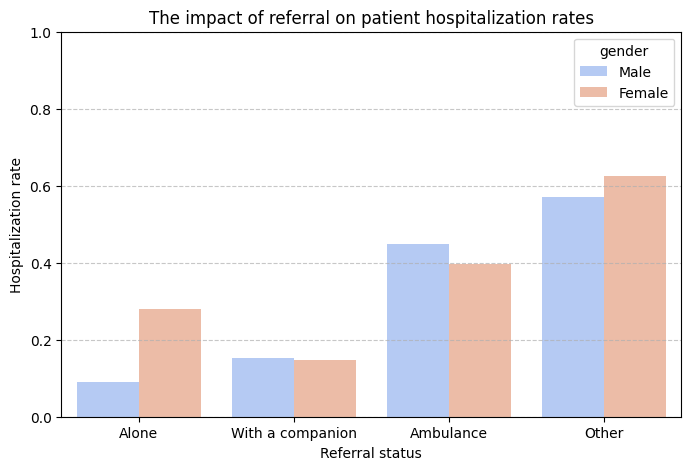

In [39]:
grouped_accident=df.groupby(['referral','gender'])['hospitalized'].mean().sort_values().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    data=grouped_accident,
    x="referral",
    y="hospitalized",
    palette="coolwarm",
    hue='gender'
)
plt.title("The impact of referral on patient hospitalization rates")
plt.xlabel("Referral status")
plt.ylabel("Hospitalization rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Comparison of hospitalization rates based on location of origin**

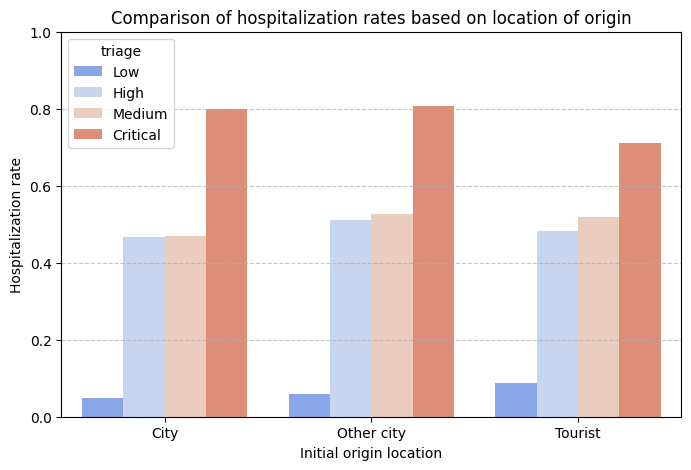

In [40]:
grouped_accident=df.groupby(['origin','triage'])['hospitalized'].mean().sort_values().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    data=grouped_accident,
    x="origin",
    y="hospitalized",
    palette="coolwarm",
    hue='triage'
)
plt.title("Comparison of hospitalization rates based on location of origin")
plt.xlabel("Initial origin location")
plt.ylabel("Hospitalization rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**The impact of visit_group on patient hospitalization rates**

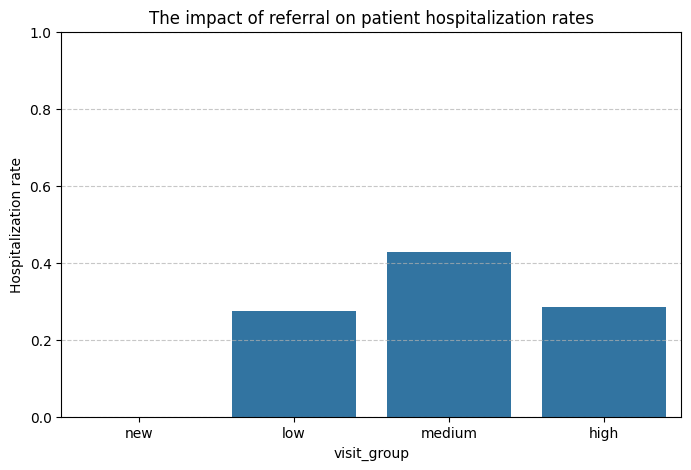

In [41]:
grouped_accident=df.groupby(['visit_group'],observed=True)['hospitalized'].mean().sort_values().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    data=grouped_accident,
    x="visit_group",
    y="hospitalized"
)
plt.title("The impact of visit_group on patient hospitalization rates")
plt.xlabel("visit_group")
plt.ylabel("Hospitalization rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**The impact of age_group on patient hospitalization rates**

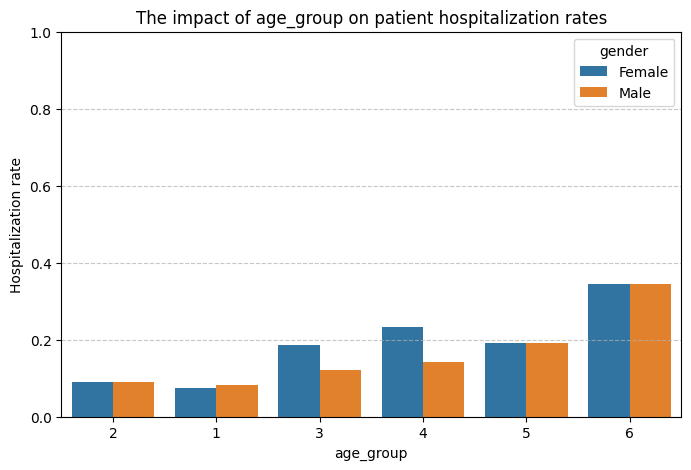

In [42]:
grouped_accident=df.groupby(['age_group','gender'],observed=True)['hospitalized'].mean().sort_values().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    data=grouped_accident,
    x="age_group",
    y="hospitalized",
    hue='gender'
)
plt.title("The impact of age_group on patient hospitalization rates")
plt.xlabel("age_group")
plt.ylabel("Hospitalization rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Numericalizing categorical columns

Numbering based on the highest hospitalization rate of each ionized value

In [43]:
columns=['triage','accident','referral','origin','gender']
for col in columns:
  hos_rate=df.groupby(col)['hospitalized'].mean().sort_values(ascending=False)
  print(hos_rate)

triage
Critical    0.798046
Medium      0.497520
High        0.484974
Low         0.053234
Name: hospitalized, dtype: float64
accident
Not accident          0.243609
Accident              0.088761
wednesday_lastyear    0.060606
Name: hospitalized, dtype: float64
referral
Other               0.597509
Ambulance           0.425716
Alone               0.193840
With a companion    0.149706
Name: hospitalized, dtype: float64
origin
Tourist       0.260306
Other city    0.236770
City          0.180751
Name: hospitalized, dtype: float64
gender
Female    0.223492
Male      0.186909
Name: hospitalized, dtype: float64


In [44]:
df['age_group'] = df['age_group'].astype(float)
df_test['age_group'] = df_test['age_group'].astype(float)

In [45]:
df['triage']=df['triage'].map({'High':2, 'Medium':3 , 'Low':1, 'Critical':4}).astype(float)
df_test['triage']=df_test['triage'].map({'High':2, 'Medium':3 , 'Low':1, 'Critical':4}).astype(float)

In [46]:
df['accident']=df['accident'].map({'Not accident':3 , 'Accident':2,'wednesday_lastyear':1}).astype(float)
df_test['accident']=df_test['accident'].map({'Not accident':3 , 'Accident':2,'wednesday_lastyear':1}).astype(float)

In [47]:
df['referral']=df['referral'].map({'Other':4,'Ambulance':3,'Alone':2,'With a companion':1}).astype(float)
df_test['referral']=df_test['referral'].map({'Other':4,'Ambulance':3,'Alone':2,'With a companion':1}).astype(float)

In [48]:
df['origin']=df['origin'].map({'Tourist':3,'Other city':2,'City':1}).astype(float)
df_test['origin']=df_test['origin'].map({'Tourist':3,'Other city':2,'City':1}).astype(float)
##
df['gender']=df['gender'].map({'Female':2,'Male':1}).astype(float)
df_test['gender']=df_test['gender'].map({'Female':2,'Male':1}).astype(float)

**Hospitalization rate per complaint code**

In [49]:
# محاسبه میانگین hospitalized برای هر complaint_code در داده آموزشی
complaint_code_mean = df.groupby('complaint_code')['hospitalized'].mean()

# تبدیل ستون complaint_code به float قبل از جایگزینی
df = df.astype({'complaint_code': 'float64'})
df_test = df_test.astype({'complaint_code': 'float64'})

# جایگزینی complaint_code با میانگین مربوطه در Train و Test با استفاده از .loc
df.loc[:, 'complaint_code'] = df['complaint_code'].map(complaint_code_mean)
df_test.loc[:, 'complaint_code'] = df_test['complaint_code'].map(complaint_code_mean)

# محاسبه میانگین complaint_code از داده آموزشی
train_complaint_mean = df['complaint_code'].mean()

# پر کردن مقادیر NaN در Test با میانگین Train
df_test.loc[:, 'complaint_code'] = df_test['complaint_code'].fillna(train_complaint_mean)

**Creating hospitalization rates based on important characteristics**

In [50]:
# محاسبه میانگین بستری برای ترکیب ویژگی‌ها (فقط از داده Train استفاده کنید!)
combine = df.groupby(
    ['triage', 'accident', 'gender', 'age_group', 'visit_group', 'referral','origin'],observed=False
).agg(combine_rate=('hospitalized', 'mean')).reset_index()
# ادغام با داده Train
df = pd.merge(
    left=df,
    right=combine[['triage', 'accident', 'gender', 'age_group', 'visit_group', 'referral', 'origin','combine_rate']],
    how='left',
    on=['triage', 'accident', 'gender', 'age_group', 'visit_group', 'referral','origin']
)

df_test = pd.merge(
    left=df_test,
    right=combine[['triage', 'accident', 'gender', 'age_group', 'visit_group', 'referral', 'origin','combine_rate']],
    how='left',
    on=['triage', 'accident', 'gender', 'age_group', 'visit_group', 'referral','origin']
)

# # پر کردن مقادیر NaN در Test با میانگین کلی Train
overall_hosp_rate = df['hospitalized'].mean()
df_test['combine_rate'] = df_test['combine_rate'].fillna(overall_hosp_rate)

**Creating critical and non-critical categories**

In [51]:
df['is_critical'] = df['triage'].isin([4,3]).astype(float)
df_test['is_critical'] = df_test['triage'].isin([4,3]).astype(float)

**Numerize the visit_group column**

In [52]:
df.groupby('visit_group',observed=True)['hospitalized'].mean().sort_values(ascending=False)

,hospitalized
visit_group,
medium,0.426740
high,0.283906
low,0.275264
new,0.000000


In [53]:
df['visit_group']=df['visit_group'].map({'medium':4,'high':3,'low':2,'new':1}).astype(float)
df_test['visit_group']=df_test['visit_group'].map({'medium':4,'high':3,'low':2,'new':1}).astype(float)

Hospitalization rate based on triage

In [54]:
triage_encoding = df.groupby('triage')['hospitalized'].mean().to_dict()
df['triage_encoded'] = df['triage'].map(triage_encoding)

df_test['triage_encoded'] = df_test['triage'].map(triage_encoding)

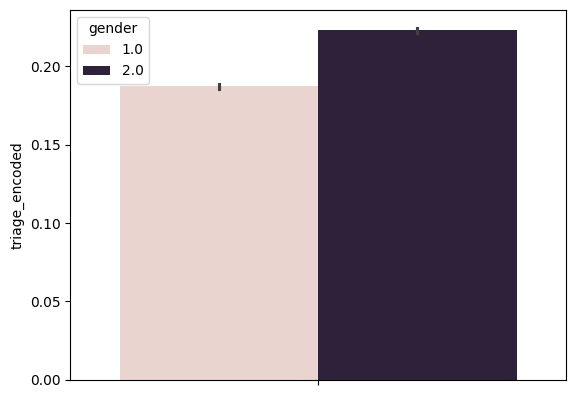

In [55]:
sns.barplot(data=df,y='triage_encoded',hue='gender')
plt.show()

In [56]:
df['visit_triage_interaction'] = df['visit_count'] * df['triage']
df_test['visit_triage_interaction'] = df_test['visit_count'] * df_test['triage']

**Checking the correlation of features**

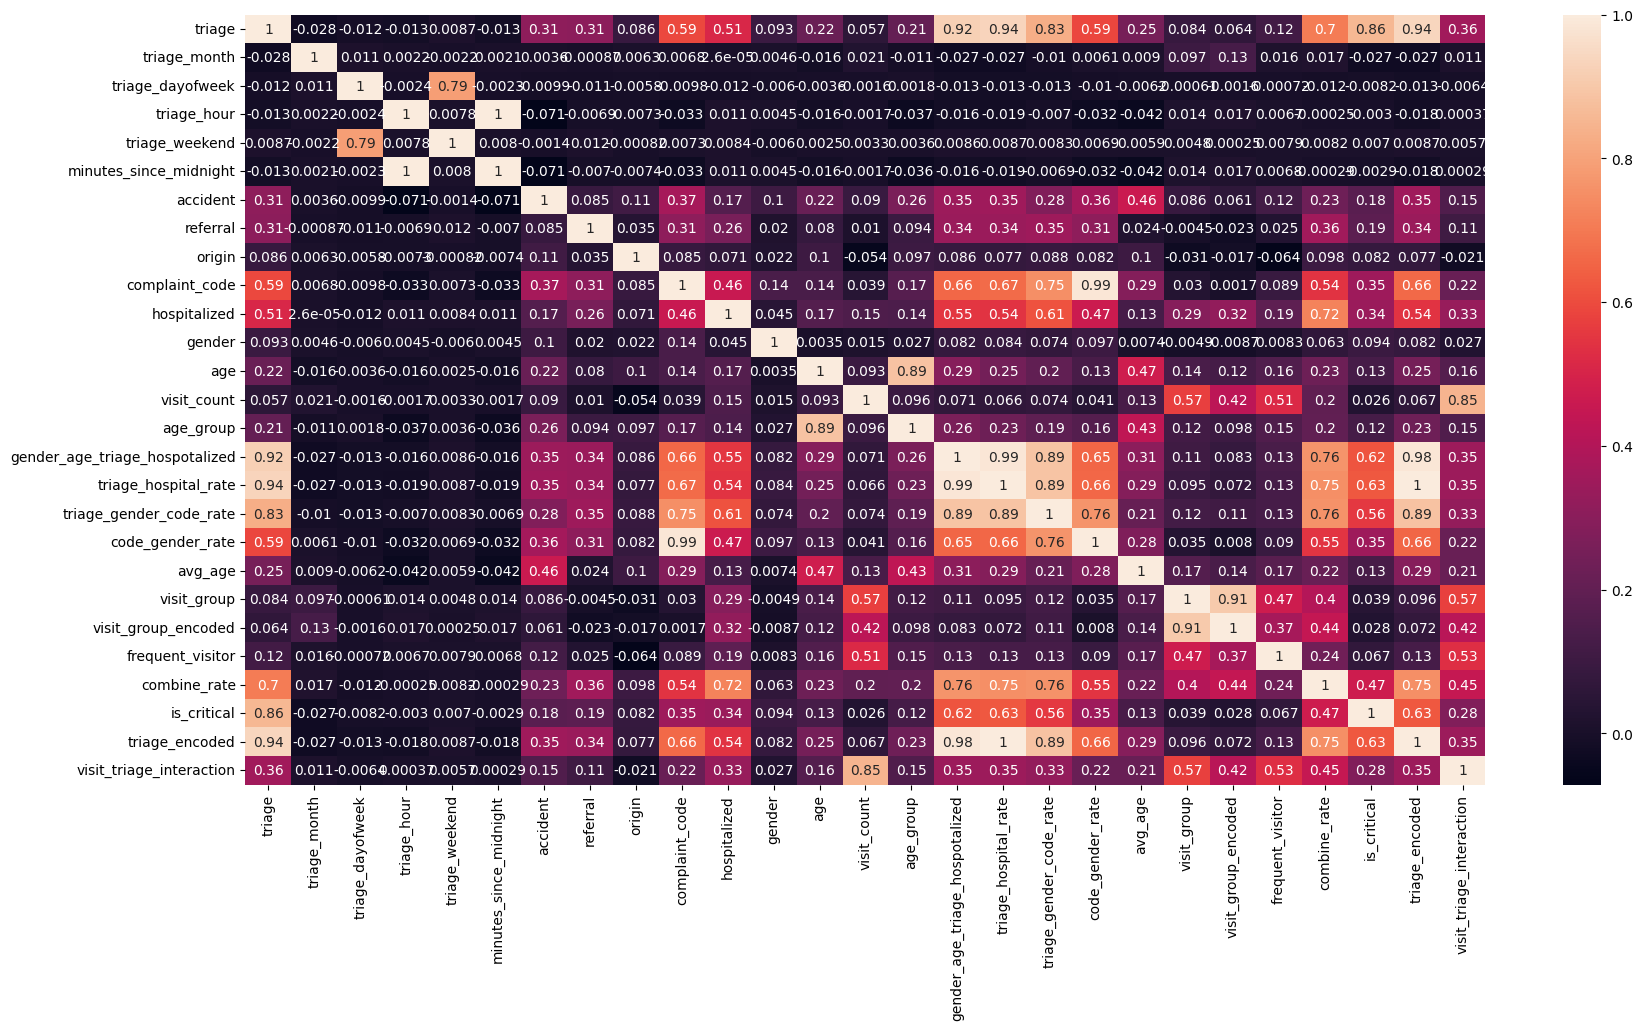

In [57]:
plt.figure(figsize=(20,10))
sns.heatmap(data=df.corr(),annot=True)
plt.show()

In [58]:
corr_matrix = df.corr()
high_corr = corr_matrix.where((corr_matrix > 0.5) & (corr_matrix < 1)).stack()

high_corr_df = high_corr.reset_index()
high_corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_df

,Feature 1,Feature 2,Correlation
0,triage,complaint_code,0.592630
1,triage,hospitalized,0.508084
2,triage,gender_age_triage_hospotalized,0.922538
3,triage,triage_hospital_rate,0.936500
4,triage,triage_gender_code_rate,0.831102
...,...,...,...
91,triage_encoded,combine_rate,0.750228
92,triage_encoded,is_critical,0.626059
93,visit_triage_interaction,visit_count,0.847813
94,visit_triage_interaction,visit_group,0.574006


**The features have a lot of collinearity.**

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(columns='hospitalized')
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data.sort_values(by='VIF',ascending=False)

,Feature,VIF
5,minutes_since_midnight,2914.126842
3,triage_hour,2759.275744
15,triage_hospital_rate,1234.346311
24,triage_encoded,1210.966898
0,triage,321.539736
17,code_gender_rate,89.598892
9,complaint_code,87.160340
14,gender_age_triage_hospotalized,76.293488
19,visit_group,74.722098
13,age_group,62.417762


In [ ]:
# df.drop(columns=['age_group','complaint_code','visit_group','triage','triage_encoded','visit_count','combine_rate','triage_hour','triage_gender_code_rate'],inplace=True)
# df_test.drop(columns=['age_group','complaint_code','visit_group','triage','triage_encoded','visit_count','combine_rate','triage_hour','triage_gender_code_rate'],inplace=True)

In [ ]:
# !pip install imbalanced-learn

In [ ]:
# from imblearn.over_sampling import SMOTE
# x = df.drop(columns='hospitalized')
# y = df['hospitalized']
# over=SMOTE(sampling_strategy='auto')
# x_sampler,y_sampler=over.fit_resample(x,y)
# new_df=pd.concat(objs=[x_sampler,y_sampler],axis=1)

**Correlation of features with the target**

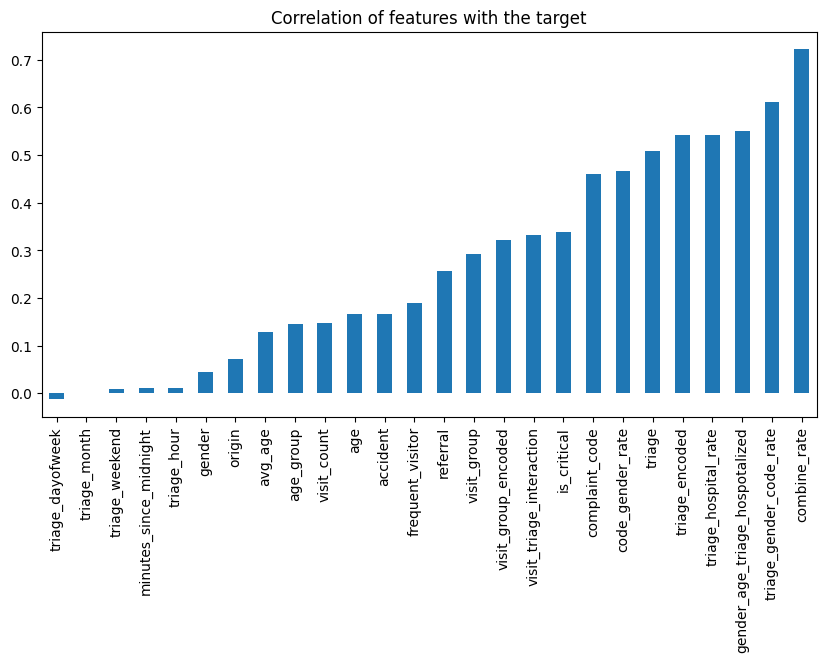

In [62]:
plt.figure(figsize=(10,5))
df.corr()['hospitalized'].sort_values()[:-1].plot(kind='bar')
plt.title('Correlation of features with the target')
plt.show()

In [63]:
df.drop_duplicates(inplace=True)

In [ ]:
# !pip install optuna
# !pip install shap

In [67]:
# pip install lightgbm
# pip install xgboost

In [64]:
df.shape

(106830, 27)

**Model training and prediction**

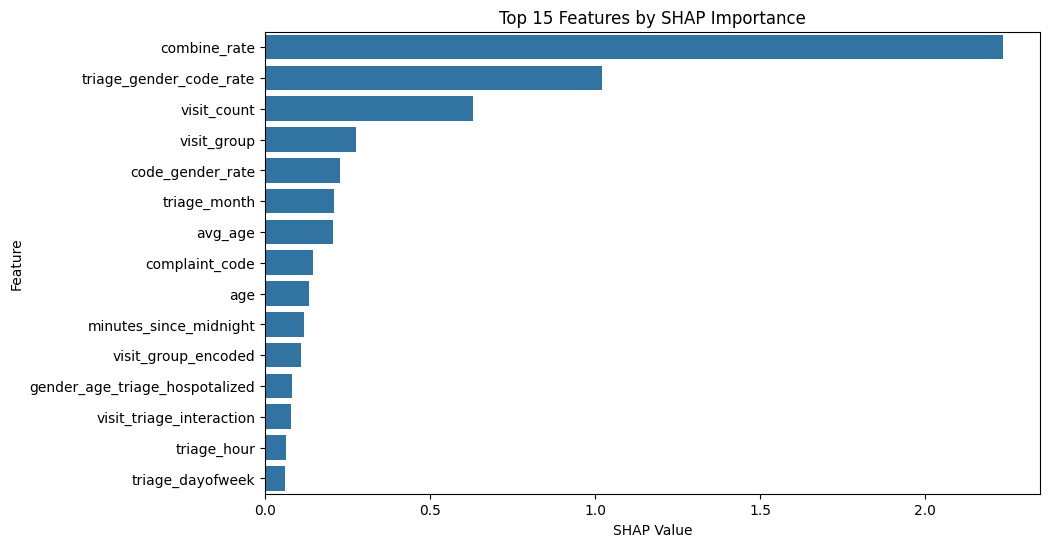

[I 2025-03-25 16:23:47,495] A new study created in memory with name: no-name-bed92b36-4f6f-43d7-844b-d7ee06543acf
[I 2025-03-25 16:24:31,851] Trial 0 finished with value: 0.7782678924413482 and parameters: {'feature_percent': 0.8637712306086109}. Best is trial 0 with value: 0.7782678924413482.
[I 2025-03-25 16:25:15,715] Trial 1 finished with value: 0.7782678924413482 and parameters: {'feature_percent': 0.8572761316295923}. Best is trial 0 with value: 0.7782678924413482.
[I 2025-03-25 16:25:54,278] Trial 2 finished with value: 0.7783139768904471 and parameters: {'feature_percent': 0.6913420338103264}. Best is trial 2 with value: 0.7783139768904471.
[I 2025-03-25 16:26:38,117] Trial 3 finished with value: 0.7782678924413482 and parameters: {'feature_percent': 0.8688222316480361}. Best is trial 2 with value: 0.7783139768904471.
[I 2025-03-25 16:27:14,089] Trial 4 finished with value: 0.777354161995986 and parameters: {'feature_percent': 0.5639918930246113}. Best is trial 2 with value: 0.

[LightGBM] [Warning] Unknown parameter: eval_metric

🚀 **گزارش عملکرد مدل روی x_test:**
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     16997
         1.0       0.73      0.84      0.78      4369

    accuracy                           0.91     21366
   macro avg       0.85      0.88      0.86     21366
weighted avg       0.91      0.91      0.91     21366



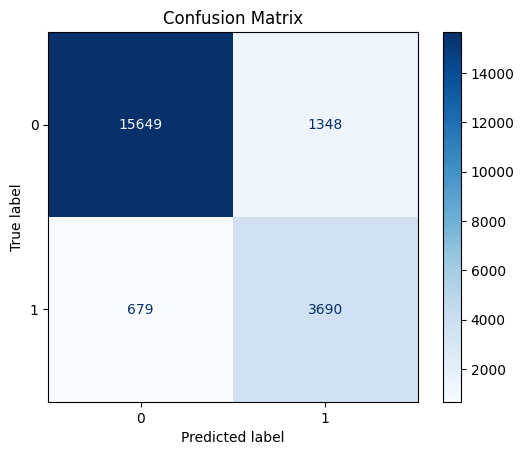

[LightGBM] [Warning] Unknown parameter: eval_metric

✅ **پیش‌بینی‌ها ذخیره شدند: `shap_optuna_threshold_predictions.csv`**


In [69]:
import shap
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# تنظیمات اولیه
SEED = 42
N_SPLITS = 5  # تعداد folds در Stratified K-Fold

# جدا کردن ویژگی‌ها و متغیر هدف
x = df.drop(columns=['hospitalized'])
y = df['hospitalized']

# تقسیم داده‌ها به Train و Test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=SEED
)

# تنظیم Stratified K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# آموزش مدل پایه XGBoost
xgb_base = XGBClassifier(
    colsample_bytree=0.5, gamma=0.1, learning_rate=0.1,
    max_depth=6, min_child_weight=3, n_estimators=250,
    subsample=0.8, scale_pos_weight=3, eval_metric='aucpr', random_state=SEED
)

xgb_base.fit(x_train, y_train)

# محاسبه SHAP
explainer = shap.Explainer(xgb_base)
shap_values = explainer(x_train)

# استخراج میانگین اهمیت ویژگی‌ها
shap_importance = np.mean(np.abs(shap_values.values), axis=0)
shap_importance_df = pd.DataFrame({'Feature': x_train.columns, 'SHAP_Importance': shap_importance})
shap_importance_df = shap_importance_df.sort_values(by='SHAP_Importance', ascending=False)

# نمایش نمودار SHAP
plt.figure(figsize=(10, 6))
sns.barplot(y=shap_importance_df['Feature'][:15], x=shap_importance_df['SHAP_Importance'][:15])
plt.title("Top 15 Features by SHAP Importance")
plt.xlabel("SHAP Value")
plt.ylabel("Feature")
plt.show()

def objective(trial):
    feature_percent = trial.suggest_float("feature_percent", 0.5, 1)
    top_features = shap_importance_df.head(int(len(shap_importance_df) * feature_percent))['Feature'].tolist()

    # تعریف مدل‌ها
    xgb = XGBClassifier(
        colsample_bytree=0.5, gamma=0.1, learning_rate=0.1,
        max_depth=6, min_child_weight=3, n_estimators=250,
        subsample=0.8, scale_pos_weight=3, eval_metric='aucpr', random_state=SEED
    )

    lgbm = LGBMClassifier(
        subsample=0.8, reg_lambda=0.5, reg_alpha=0.1,
        num_leaves=31, n_estimators=250, max_depth=6,
        learning_rate=0.1, colsample_bytree=0.7, class_weight='balanced',
        eval_metric='average_precision', random_state=SEED
    )

    stack_model = StackingClassifier(
        estimators=[('xgb', xgb), ('lgbm', lgbm)],
        final_estimator=XGBClassifier(n_estimators=50, learning_rate=0.05, max_depth=3, random_state=SEED),
        cv=skf, n_jobs=-1, passthrough=True, stack_method='predict_proba'
    )

    scores = cross_val_score(stack_model, x_train[top_features], y_train, cv=skf, scoring='f1', n_jobs=-1)
    return np.mean(scores)

# اجرای Optuna برای یافتن بهترین درصد ویژگی‌ها
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# دریافت بهترین ویژگی‌ها
best_feature_percent = study.best_params["feature_percent"]
top_features_final = shap_importance_df.head(int(len(shap_importance_df) * best_feature_percent))['Feature'].tolist()

# مدل Stacking نهایی
final_model = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(colsample_bytree=0.5, gamma=0.1, learning_rate=0.1,
                              max_depth=6, min_child_weight=3, n_estimators=250,
                              subsample=0.8, scale_pos_weight=3, eval_metric='aucpr', random_state=SEED)),
        ('lgbm', LGBMClassifier(subsample=0.8, reg_lambda=0.5, reg_alpha=0.1,
                                num_leaves=31, n_estimators=250, max_depth=6,
                                learning_rate=0.1, colsample_bytree=0.7, class_weight='balanced',
                                eval_metric='average_precision', random_state=SEED))
    ],
    final_estimator=XGBClassifier(n_estimators=50, learning_rate=0.05, max_depth=3, random_state=SEED),
    cv=skf, n_jobs=-1, passthrough=True, stack_method='predict_proba'
)

final_model.fit(x_train[top_features_final], y_train)
y_scores = final_model.predict_proba(x_test[top_features_final])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

if len(thresholds) > 0:
    best_thresh = thresholds[np.argmax((2 * precision * recall) / (precision + recall + 1e-10))]
else:
    best_thresh = 0.5

y_pred_test = (y_scores > best_thresh).astype(int)

# گزارش عملکرد مدل
print("\n🚀 **گزارش عملکرد مدل روی x_test:**")
print(classification_report(y_test, y_pred_test))

# نمایش Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

common_features = [col for col in top_features_final if col in df_test.columns]
x_test_final = df_test[common_features]
y_pred_df = pd.DataFrame({'hospitalized': (final_model.predict_proba(x_test_final)[:, 1] > best_thresh).astype(int)}, index=df_test.index)

# ذخیره خروجی در CSV
y_pred_df.to_csv('shap_optuna_threshold_predictions.csv', index=False)
print("\n✅ **پیش‌بینی‌ها ذخیره شدند: `shap_optuna_threshold_predictions.csv`**")
